## Imports

In [2]:
#Commonted out the below lines as the packages are already installed in the environment

# !pip install timm
# !pip install nibabel
# !pip install nilearn
# !pip install light-the-torch && ltt install torch
#!pip install torchio

import tensorflow as tf
#for neuroimaging data
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import os



c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
from tempfile import TemporaryDirectory


In [4]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [5]:
# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {torch.cuda.get_device_name()} for inference' if torch.cuda.is_available() else 'Using CPU for inference')

Using NVIDIA GeForce RTX 3060 Laptop GPU for inference


## Dataset 

In [6]:
root_dir = 'Dataset'

# List all subdirectories in the root directory
subdirectories = [x[0] for x in os.walk(root_dir)]

dataset = []

# Iterate over the subdirectories
for subdir in subdirectories:
    # Check if the subdirectory contains 'anat' in its path
    if 'anat' in subdir:
        # List all files in the subdirectory
        files = os.listdir(subdir)
        # Iterate over the files
        for file in files:
            # Check if the file is a .nii.gz file
            if file.endswith('.nii.gz'):
                file_path = os.path.join(subdir, file)
                # Load the Nifti image using TorchIO
                subject = tio.Subject(
                    mri = tio.ScalarImage(file_path),
                )
                dataset.append(subject)
       

# Print the number of images in the dataset
print('Number of Images in Dataset: ' + str(len(dataset)))

print('First Image Dimensions in Dataset: ')
print(dataset[0].spatial_shape)


Number of Images in Dataset: 777
First Image Dimensions in Dataset: 
(256, 200, 256)


## Import Labels

In [7]:
# check if a file named participants.tsv exists in the each of the subfolder under the root directory
# If it exists, load the file and display the contents
for subdir in subdirectories:
    if os.path.exists(os.path.join(subdir, 'participants.csv')):
        print('Found participants.tsv in ' + subdir)
        df = pd.read_csv(os.path.join(subdir, 'participants.csv'), sep=',', header=0)

for subject in dataset:
    adhd_label = df['dx'].values[0]
    adhd_label = 1 if adhd_label != 'Typically Developing Children' else 0
    subject['adhd'] = adhd_label

Found participants.tsv in Dataset\KKI
Found participants.tsv in Dataset\NeuroIMAGE
Found participants.tsv in Dataset\NYU
Found participants.tsv in Dataset\OHSU
Found participants.tsv in Dataset\Peking_1
Found participants.tsv in Dataset\Peking_2
Found participants.tsv in Dataset\Peking_3


## Image Preprocessing

In [8]:
transforms = [
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.CropOrPad((256, 256, 256))
]
transform = tio.Compose(transforms)
subjects_dataset = tio.SubjectsDataset(dataset, transform=transform)
print(len(subjects_dataset))

777


ADHD Label: 0


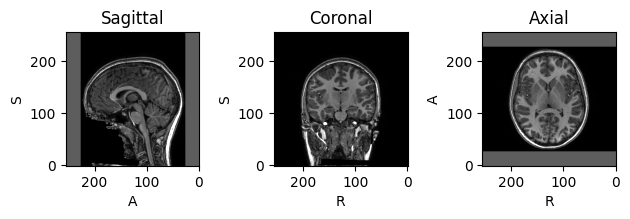

(256, 256, 256)
ADHD Label: 0


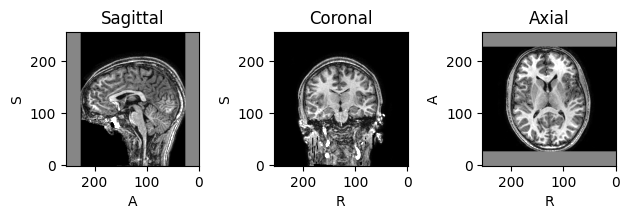

(256, 256, 256)
ADHD Label: 0


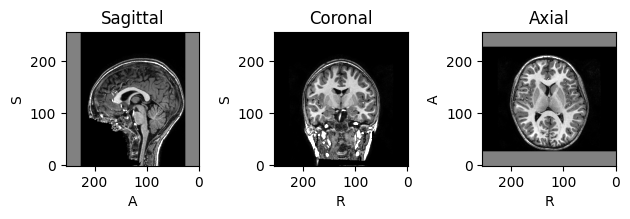

(256, 256, 256)
ADHD Label: 0


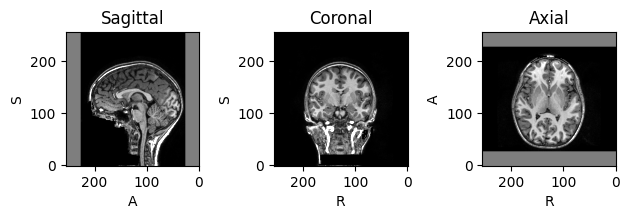

(256, 256, 256)
ADHD Label: 0


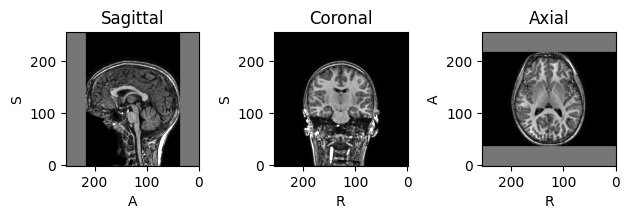

(256, 256, 256)


In [9]:
#Shows the preprocessed images
for i in range(5):
    subject = subjects_dataset[i]
    image = subject['mri']
    print('ADHD Label: ' + str(subject['adhd']))
    image.plot()
    plt.show()
    print(subjects_dataset[i]['mri'].spatial_shape)

## Train/Test Split

In [10]:
# Set the seed for reproducibility
torch.manual_seed(42)


# split the torchio dataset into train/test with a 80/20 ratio
n = len(subjects_dataset)
n_train = int(0.8 * n)
n_val = n - n_train
train_dataset, val_dataset = torch.utils.data.random_split(subjects_dataset, [n_train, n_val])


# Data Loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True)


## Pre-Trained Model

In [12]:
import torch
import torchvision.models as models

# Load the pre-trained CNN model for neuorimaging data
model = torchvision.models.video.r3d_18(pretrained=True, progress=True)

# Modify the first layer to accept 1 channel
model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

# Modify the fully connected layer
model.fc = nn.Linear(512, 2)

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the model architecture
print(model)
model = model.to(device)


VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

## Training

## Evaluation